# Telecom operator Interconnect
## customer churn prediction

#### The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts. 

#### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.  

#### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

In [1]:
#pip install -U pandas
#pip install -U numpy
#pip install -U seaborn
#pip install -U matplotlib
#pip install -U scikit-learn

## 1) Data Preprocessing

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer 
from sklearn.dummy import DummyClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier 
from sklearn import set_config
set_config(display='diagram')

In [3]:
personal= pd.read_csv('personal.csv')
phone= pd.read_csv('phone.csv')
internet= pd.read_csv('internet.csv')
contract= pd.read_csv('contract.csv')

#### Personal info

In [4]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


- no missing values found 

#### Phone info

In [6]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [7]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


- no missing values found

#### Internet info

In [8]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


- no missing values found

#### Contract info

In [10]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [11]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


- no missing values were found  

let's merge the 4 datasets:

In [12]:
df= personal.merge(phone, on='customerID', how='left').merge(internet, on='customerID', how='left').merge(contract, on='customerID', how='left')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   MultipleLines     6361 non-null   object 
 6   InternetService   5517 non-null   object 
 7   OnlineSecurity    5517 non-null   object 
 8   OnlineBackup      5517 non-null   object 
 9   DeviceProtection  5517 non-null   object 
 10  TechSupport       5517 non-null   object 
 11  StreamingTV       5517 non-null   object 
 12  StreamingMovies   5517 non-null   object 
 13  BeginDate         7043 non-null   object 
 14  EndDate           7043 non-null   object 
 15  Type              7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [14]:
df[df['EndDate']!='No']['EndDate'].max()

'2020-01-01 00:00:00'

- seeing as the most recent date in the 'EndDate' feature is 2020-01-01 and given that the dataset is relevant up untill 2020-02-01, we can fill in the NaT fields with the current date (i.e. 2020-02-01). users with the current date as endDate will be deemeed as current customers, and users with any endDate prior to the current date will be deemed as churned (former customers who dropped out of service).

In [15]:
current= pd.to_datetime('2020-02-01')
current

Timestamp('2020-02-01 00:00:00')

In [16]:
df.EndDate= df.EndDate.replace('No',current)

In [17]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,2020-01-01,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,2020-02-01 00:00:00,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,2020-02-01 00:00:00,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


let's change the date values into type 'datetime':

In [18]:
df['BeginDate']= pd.to_datetime(df['BeginDate'])
df['EndDate']= pd.to_datetime(df['EndDate'])

- the 'TotalCharges' feature is oftype 'object' instead of 'float', which means there must be whilte spaces, let's fill them in:

In [19]:
df['TotalCharges']= df['TotalCharges'].replace(r'\s+', np.nan, regex=True)

In [20]:
df[df['TotalCharges'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,Female,0,Yes,Yes,NaN,DSL,Yes,No,Yes,Yes,Yes,No,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,Male,0,No,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,Female,0,Yes,Yes,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,Female,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


- as can be seen, these values belong to new joining customers so the NaN values in the 'TotalCharges' feature can be filled with 0:

In [21]:
df['TotalCharges']= df['TotalCharges'].fillna(0)
df['TotalCharges']=df['TotalCharges'].astype('float')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   MultipleLines     6361 non-null   object        
 6   InternetService   5517 non-null   object        
 7   OnlineSecurity    5517 non-null   object        
 8   OnlineBackup      5517 non-null   object        
 9   DeviceProtection  5517 non-null   object        
 10  TechSupport       5517 non-null   object        
 11  StreamingTV       5517 non-null   object        
 12  StreamingMovies   5517 non-null   object        
 13  BeginDate         7043 non-null   datetime64[ns]
 14  EndDate           7043 n

- creating target variable 'churn' to indicate current clients from former ones: 

In [23]:
def dropout_client(end):
    if end!=current:
        return 1
    else:
        return 0

In [24]:
df['churn']= df.EndDate.apply(dropout_client)

In [25]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn
0,7590-VHVEG,Female,0,Yes,No,NaN,DSL,No,Yes,No,...,No,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,...,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,...,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,NaN,DSL,Yes,No,Yes,...,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,...,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


- feature engineering: let's calculate the contract duration in days rather than months (so as to introduce more variability to the otherwise homogenous datasets):

In [26]:
df['duration_days']= ((df.EndDate- df.BeginDate)/(np.timedelta64(1, 'D'))).round(1) 
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,duration_days
0,7590-VHVEG,Female,0,Yes,No,NaN,DSL,No,Yes,No,...,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31.0
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,...,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036.0
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,...,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61.0
3,7795-CFOCW,Male,0,No,No,NaN,DSL,Yes,No,Yes,...,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371.0
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,...,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61.0


- we can drop the 'customerID', 'BeginDate' and 'EndDate' features since they are no longer required:

In [27]:
df= df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [28]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,duration_days
0,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,31.0
1,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1036.0
2,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,61.0
3,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371.0
4,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,61.0


In [29]:
df.churn.value_counts(normalize=True)

0    0.73463
1    0.26537
Name: churn, dtype: float64

In [30]:
df.shape

(7043, 19)

- since there are relatively few samples, some class imbalance and mostly categorical features, let's replace the categorical values with numeric values, thus minimizing dimentionality:

In [31]:
yes_no= {'No':0, 'Yes':1}
lines= {'No':1, 'Yes':2}
internet= {'DSL':1, 'Fiber optic':2}
gender= {'Female':0, 'Male':1}
Type= {'Month-to-month':0, 'One year':1, 'Two year':2}
payment= {'Electronic check':0, 'Mailed check':1, 'Bank transfer (automatic)':2, 'Credit card (automatic)':3}

In [32]:

df['OnlineSecurity']= df['OnlineSecurity'].map(yes_no)
df['OnlineBackup']= df['OnlineBackup'].map(yes_no)
df['DeviceProtection']= df['DeviceProtection'].map(yes_no)
df['TechSupport']= df['TechSupport'].map(yes_no)
df['StreamingTV']= df['StreamingTV'].map(yes_no)
df['StreamingMovies']= df['StreamingMovies'].map(yes_no)
df['PaperlessBilling']= df['PaperlessBilling'].map(yes_no)
df['MultipleLines']= df['MultipleLines'].map(lines)
df['InternetService']= df['InternetService'].map(internet)
df['gender']= df['gender'].map(gender)
df['Type']= df['Type'].map(Type)
df['PaymentMethod']= df['PaymentMethod'].map(payment)
df['Partner']= df['Partner'].map(yes_no)
df['Dependents']= df['Dependents'].map(yes_no)

In [33]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,duration_days
0,0,0,1,0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,29.85,29.85,0,31.0
1,1,0,0,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0,1,56.95,1889.50,0,1036.0
2,1,0,0,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1,1,53.85,108.15,1,61.0
3,1,0,0,0,NaN,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1,0,2,42.30,1840.75,0,1371.0
4,0,0,0,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,70.70,151.65,1,61.0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   MultipleLines     6361 non-null   float64
 5   InternetService   5517 non-null   float64
 6   OnlineSecurity    5517 non-null   float64
 7   OnlineBackup      5517 non-null   float64
 8   DeviceProtection  5517 non-null   float64
 9   TechSupport       5517 non-null   float64
 10  StreamingTV       5517 non-null   float64
 11  StreamingMovies   5517 non-null   float64
 12  Type              7043 non-null   int64  
 13  PaperlessBilling  7043 non-null   int64  
 14  PaymentMethod     7043 non-null   int64  
 15  MonthlyCharges    7043 non-null   float64
 16  TotalCharges      7043 non-null   float64


In [35]:
df= df.fillna(0)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   MultipleLines     7043 non-null   float64
 5   InternetService   7043 non-null   float64
 6   OnlineSecurity    7043 non-null   float64
 7   OnlineBackup      7043 non-null   float64
 8   DeviceProtection  7043 non-null   float64
 9   TechSupport       7043 non-null   float64
 10  StreamingTV       7043 non-null   float64
 11  StreamingMovies   7043 non-null   float64
 12  Type              7043 non-null   int64  
 13  PaperlessBilling  7043 non-null   int64  
 14  PaymentMethod     7043 non-null   int64  
 15  MonthlyCharges    7043 non-null   float64
 16  TotalCharges      7043 non-null   float64


### Conclusions: 

- our data is composed of 4 sub datasets: personal info of the customers, phone serice, internet serice and each customer's contract info. 
- dates of type 'object' were converted to datetime type.
- date type missing values (NaT) were replaced with the current date (i.e. 2020-02-01) to reflect the fact that these are ongoing current customers, whereas endDates prior to the current on reflect churned customers (i.e. former customers). 
- a target feature has been added to the set, based on wheather or not a customer has churned.
- an additional sample feature has been added to note the length of a customer's contract, measured in months. 

## 2) EDA

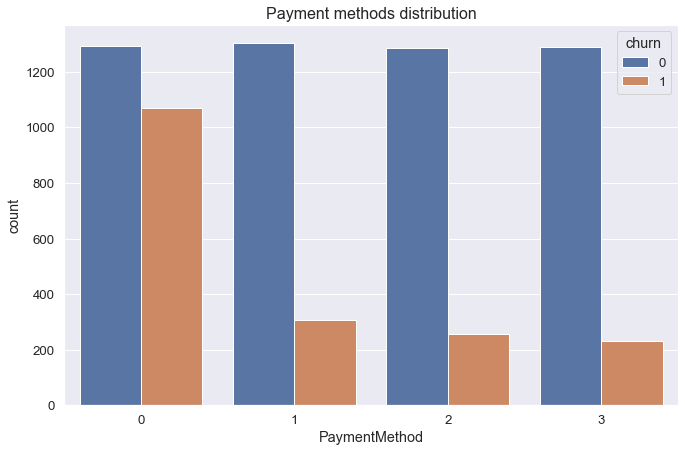

In [37]:
sns.set(rc = {'figure.figsize':(11,7)}, font_scale=1.2)
sns.countplot(data= df, x='PaymentMethod', hue='churn').set_title('Payment methods distribution', fontsize=16);

Where: Electronic check= 0, Mailed check= 1, Bank transfer (automatic)= 2, Credit card (automatic)= 3 
***********  
- the current customers are roughly evenly distributed between the 4 different paying methods, whereas the former clients seemed to prefer the electronic check paying method. perhaps this process was faulty, causing customer dissatisfaction, influencing their decission to leave.

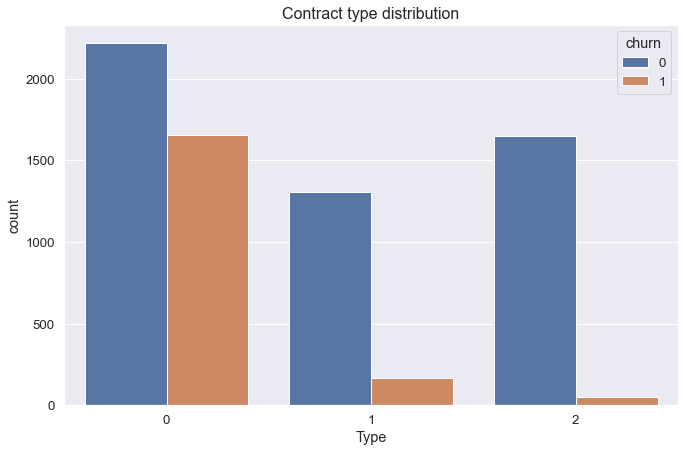

In [38]:
sns.countplot(data= df, x='Type', hue='churn').set_title('Contract type distribution', fontsize=16);

Where: Month-to-month= 0, One year= 1, Two year= 2  
****** 
- it seems like the longer the contract is, the larger the ratio is of current clients Vs former ones. 

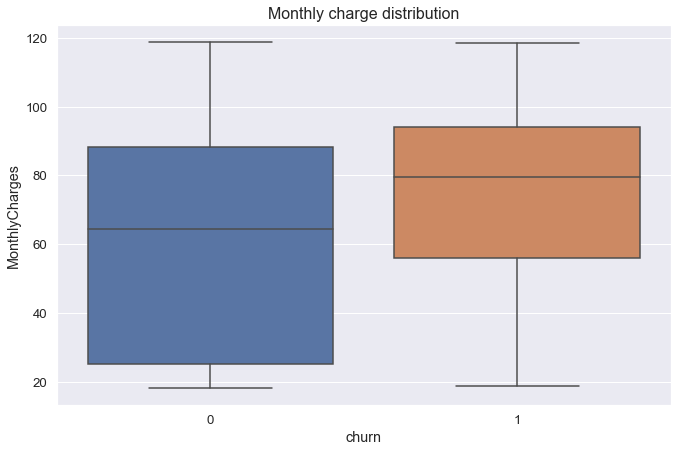

In [39]:
sns.boxplot(data=df, x='churn', y='MonthlyCharges').set_title('Monthly charge distribution', fontsize=16);

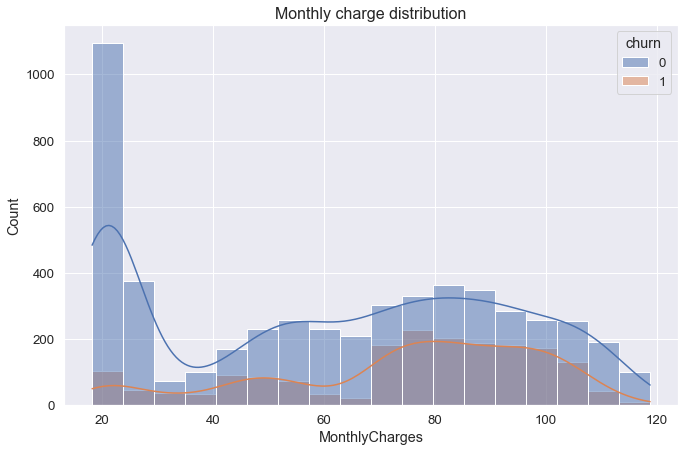

In [40]:
sns.histplot(x=df['MonthlyCharges'], hue=df['churn'], kde=True).set_title('Monthly charge distribution', fontsize=16);

- from both the boxplot and the histplot, we can see that the median value of the monthly rates for the current customer group is lower at around 65 compared with about 80 of the former ones. 
- no outlier values have been detected in either group. 

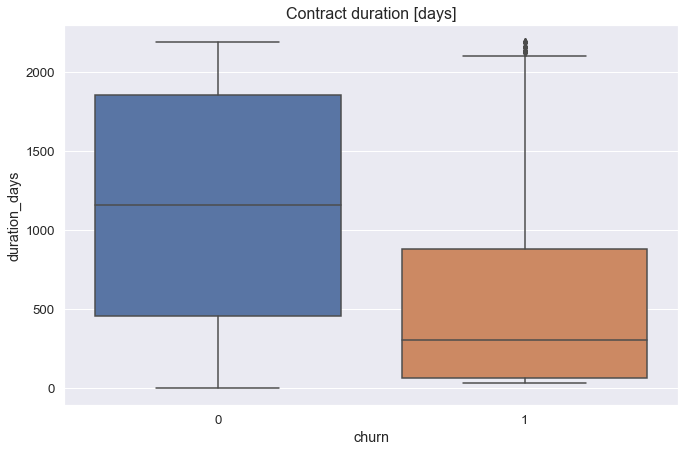

In [41]:
sns.boxplot(x=df['churn'], y=df['duration_days']).set_title('Contract duration [days]', fontsize=16);

In [42]:
df[df.churn==1]['duration_days'].describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: duration_days, dtype: float64

In [43]:
q75_f, q25_f = np.percentile(df[df.churn==1]['duration_days'], [75 ,25])
IQR_former = q75_f - q25_f
IQR_former

822.0

In [44]:
top_f= q75_f+IQR_former*1.5
top_f

2116.0

In [45]:
df[(df.churn==1) & (df.duration_days>=top_f)].shape[0]

23

- although there are 23 sample with longer contract subscription, we can leave them in rather than remove them, due to their small number and the fact that they all belong to the (relative) minority class (former customers).

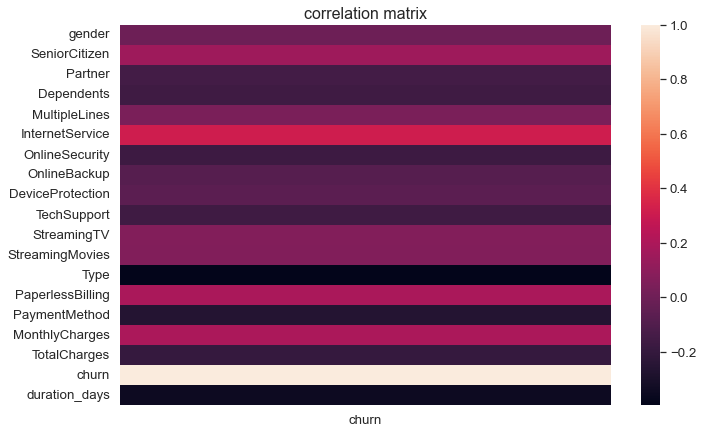

In [46]:
sns.heatmap(df.corr()[['churn']]).set_title('correlation matrix', fontsize=16);

- There seem to be a correlation between Internet services and churn:

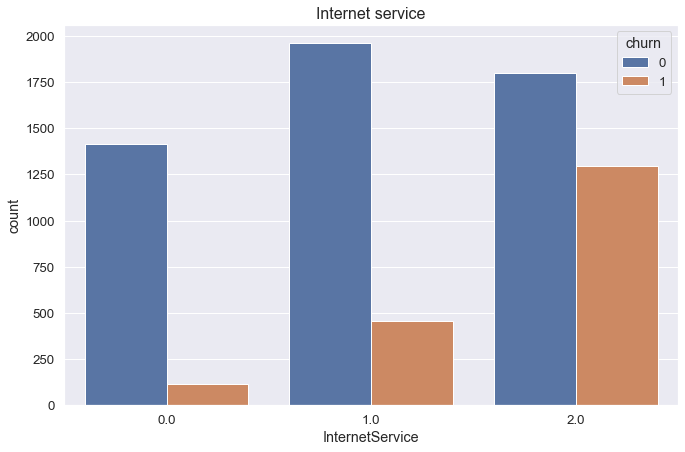

In [47]:
sns.countplot(data=df, x='InternetService', hue='churn').set_title('Internet service', fontsize=16);

Where: No internet service= 0, DSL= 1, Fiber optic= 2  
***** 
- within the current customers there are more than twice internet consumers compared to non-internet consumers. 
- the smallest ratio of churned to current customers is found within the non-internet consumers group. 
- the highest ratio of churned customers to current ones is found within the Fiber optics service group. 


maybe this sugests a problematic Fiber-optics service such that people who were mainly relying on this service were dissapointed and decided to leave, as opposed to people who relied on other communication services the company offered and therefore were less affected by the sub optimal Fiber-optics service.

## 3) Modeling and Predictions

#### f1 score would be the best metric for this business problem, as it takes into account both recall and precision which are both relevant.

- setting the train and test (validation) data sets

In [48]:
X= df.drop('churn', axis=1)
y= df.churn

In [49]:
print(X.shape, y.shape)

(7043, 18) (7043,)


In [50]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, random_state=42)

In [51]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5282, 18) (1761, 18) (5282,) (1761,)


In [52]:
columns= X.columns.tolist()

In [53]:
preprocessor= make_column_transformer((MinMaxScaler(), columns))
smote= SMOTE(random_state=42)

#### Dummy Classifier

In [54]:
dummy= DummyClassifier(random_state=42, strategy='stratified') 
dummy_pipe= make_pipeline(preprocessor, smote, dummy)

In [55]:
dummy.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='stratified')

In [56]:
y_dummy= dummy.predict(X_test)
print(classification_report(y_test, y_dummy))

              precision    recall  f1-score   support

           0       0.73      0.74      0.74      1282
           1       0.28      0.27      0.28       479

    accuracy                           0.61      1761
   macro avg       0.51      0.51      0.51      1761
weighted avg       0.61      0.61      0.61      1761



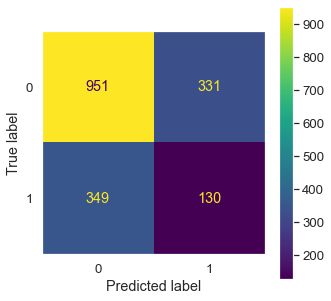

In [57]:
sns.set(rc = {'figure.figsize':(5,5)}, font_scale=1.2)
ConfusionMatrixDisplay.from_predictions(y_test, y_dummy)
plt.grid(False)
plt.show()

#### RandomForest classifer

In [58]:
rndForest= RandomForestClassifier(random_state=42, class_weight='balanced')
rndForest_pipe= make_pipeline(preprocessor, smote, rndForest)

In [59]:
#rndForest_pipe.get_params().keys()

In [60]:
params_rndForest= dict(randomforestclassifier__n_estimators=[250, 300, 350], randomforestclassifier__max_depth= [6,8,10])

In [61]:
randomForest= GridSearchCV(rndForest_pipe, param_grid= params_rndForest, scoring='f1')

In [62]:
randomForest.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'duration_days'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': [6, 8, 10],
                         'randomforestclassifier__n_estimators': [250, 300,
                                                                  350]},
             scoring='f1')

In [63]:
print('the best parameters for Random Forest are:\n', randomForest.best_params_)

the best parameters for Random Forest are:
 {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 350}


In [64]:
print('f1 score for Random Forest:', randomForest.best_score_.round(2))

f1 score for Random Forest: 0.64


In [65]:
y_rndForest= randomForest.predict(X_test)
print(classification_report(y_test, y_rndForest))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1282
           1       0.59      0.78      0.67       479

    accuracy                           0.79      1761
   macro avg       0.75      0.79      0.76      1761
weighted avg       0.82      0.79      0.80      1761



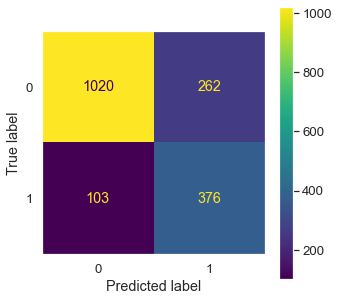

In [66]:
ConfusionMatrixDisplay.from_predictions(y_test, y_rndForest)
plt.grid(False)
plt.show()

#### Gradient Boosting classifier

In [67]:
gdb= GradientBoostingClassifier(random_state=42)
gdb_pipe= make_pipeline(preprocessor, smote, gdb)

In [68]:
#gdb_pipe.get_params().keys()

In [69]:
params_gdb= dict(gradientboostingclassifier__learning_rate= [0.3, 0.4, 0.5], gradientboostingclassifier__n_estimators=[200, 300, 400], gradientboostingclassifier__max_depth=[2,3,4,5])

In [70]:
gboosting= GridSearchCV(gdb_pipe, param_grid= params_gdb, scoring='f1')

In [71]:
gboosting.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'duration_days'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'gradientboostingclassifier__learning_rate': [0.3, 0.4,
                                                                       0.5],
                         'gradientboostingclassifier__max_depth': [2, 3, 4, 5],
                         'gradientboostingclassifier__n_estimators': [200, 300,
                                                                      400]},
             scoring='f1')

In [72]:
print('the best parameters for Random Forest are:\n', gboosting.best_params_)

the best parameters for Random Forest are:
 {'gradientboostingclassifier__learning_rate': 0.4, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__n_estimators': 400}


In [73]:
print('f1 score for GradientBoosting:', gboosting.best_score_.round(2))

f1 score for GradientBoosting: 0.74


In [74]:
y_gdb= gboosting.predict(X_test)
print(classification_report(y_test, y_gdb))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1282
           1       0.82      0.76      0.79       479

    accuracy                           0.89      1761
   macro avg       0.87      0.85      0.86      1761
weighted avg       0.89      0.89      0.89      1761



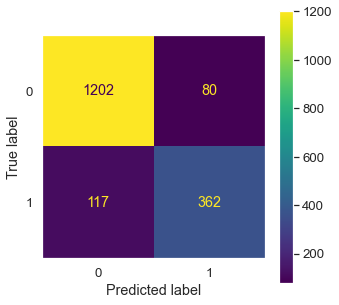

In [75]:
ConfusionMatrixDisplay.from_predictions(y_test, y_gdb)
plt.grid(False)
plt.show()

#### AdaBoost classifier

In [76]:
adab= AdaBoostClassifier(random_state=42)
ada_pipe= make_pipeline(preprocessor, smote, adab)

In [77]:
#ada_pipe.get_params().keys()

In [78]:
params_ada= dict(adaboostclassifier__learning_rate=[1.0, 1.5, 2.0], adaboostclassifier__n_estimators=[ 500, 600, 700])

In [79]:
ada_boost= GridSearchCV(ada_pipe, param_grid= params_ada, scoring='f1')

In [80]:
ada_boost.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'duration_days'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('adaboostclassifier',
                                        AdaBoostClassifier(random_state=42))]),
             param_grid={'adaboostclassifier__learning_rate': [1.0, 1.5, 2.0],
                         'adaboostclassifier__n_estimators': [500, 600, 700]},
             scoring='f1')

In [81]:
print('the best parameters for AdaBoost are:\n', ada_boost.best_params_)

the best parameters for AdaBoost are:
 {'adaboostclassifier__learning_rate': 1.5, 'adaboostclassifier__n_estimators': 700}


In [82]:
print('f1 score for AdaBoost:', ada_boost.best_score_.round(2))

f1 score for AdaBoost: 0.68


In [83]:
y_adab= ada_boost.predict(X_test)
print(classification_report(y_test, y_adab))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1282
           1       0.75      0.72      0.74       479

    accuracy                           0.86      1761
   macro avg       0.82      0.82      0.82      1761
weighted avg       0.86      0.86      0.86      1761



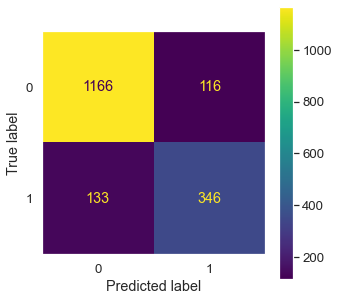

In [84]:
ConfusionMatrixDisplay.from_predictions(y_test, y_adab)
plt.grid(False)
plt.show()

#### Logistic Regression

In [85]:
lr= LogisticRegression(random_state=42, class_weight='balanced')
lr_pipe= make_pipeline(preprocessor, smote,  lr)

In [86]:
#lr_pipe.get_params().keys()

In [87]:
params_lr= dict(logisticregression__C= [1, 1.5, 2.0, 3.0, 4.0], logisticregression__class_weight=['balanced'], logisticregression__solver=['newton-cg', 'lbfgs', 'liblinear', 'saga'], logisticregression__max_iter=[6000])

In [88]:
logistic_reg= GridSearchCV(lr_pipe, param_grid= params_lr, scoring='f1')

In [89]:
logistic_reg.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'Mont...
                                                                          'duration_days'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             param_grid={'logisticregression__C': [1, 1.5, 2.0, 3.0, 4.0],
                         'logisticregression__class_weight': ['balanced'],
                         'logisticregression__max_iter': [6000],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                        'liblinear', 'saga']},
             scoring='f1')

In [90]:
print('the best parameters for Logistic Regression are:\n', logistic_reg.best_params_)

the best parameters for Logistic Regression are:
 {'logisticregression__C': 1.5, 'logisticregression__class_weight': 'balanced', 'logisticregression__max_iter': 6000, 'logisticregression__solver': 'newton-cg'}


In [91]:
print('f1 score for Logistic Regression:', logistic_reg.best_score_.round(2))

f1 score for Logistic Regression: 0.62


In [92]:
y_lr= logistic_reg.predict(X_test)
print(classification_report(y_test, y_lr))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82      1282
           1       0.55      0.83      0.66       479

    accuracy                           0.77      1761
   macro avg       0.73      0.79      0.74      1761
weighted avg       0.82      0.77      0.78      1761



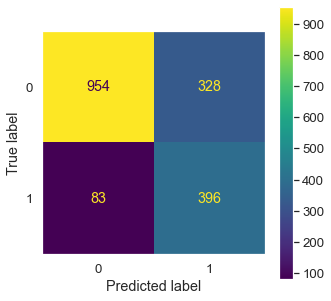

In [93]:
ConfusionMatrixDisplay.from_predictions(y_test, y_lr)
plt.grid(False)
plt.show()

## Conclussions

- 5 classifiers have been examined: dummy, Random Forest, GradientBoosting, AdaBoost and LogisticRegression. 
- all 4 models performed better than the dummy classifier in f1 scoring. 
- GradientBoosting had the highest f1 score: 0.79, more than 2.5 the baseline estimator. 
- in view of the business problem in question, the optimal classifier would be GradientBoosting, since it offers the highest f1 score in detecting churn prone customers. 